In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
from fastai.vision import *
from fastai.metrics import error_rate

torch.manual_seed(121)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(121)

In [3]:
df = pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
labels = np.array(df.iloc[:, 1:])
labels = np.where(labels==1)[1]

df['label'] = labels
df.to_csv('./train_data.csv', index=False)

In [4]:
BS = 32
IMG_SZ = 320
# CLASS_WT = torch.FloatTensor([1.0, 1.0, 1.0, 1.0]).cuda()

label_dict = {0: 'healthy',
              1: 'multiple_diseases',
              2: 'rust',
              3: 'scab',
              'micro': 'micro',
              'macro': 'macro',
             }

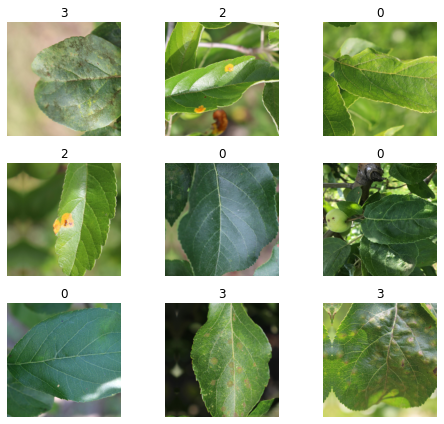

In [5]:
data_tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=None, max_zoom=1.1, max_lighting=None,
                          max_warp=0, p_affine=0, p_lighting=0)

data = ImageDataBunch.from_csv('../input/plant-pathology-2020-fgvc7', csv_labels='../../working/train_data.csv', folder='images', 
                               label_col=5, suffix='.jpg', valid_pct=0.15, ds_tfms=data_tfms, seed=0,
                               bs=BS, size=IMG_SZ).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,6))

In [6]:
from sklearn.metrics import roc_curve, auc
class AUC(Callback):

    def __init__(self, num_cl, pick='micro'):
        self.id_to_class = label_dict
        self.name = str(self.id_to_class[pick])+'-AUC'
        self.pick = pick
        self.num_cl = num_cl
        
    
    def on_epoch_begin(self, **kwargs):
        self.outputs, self.targets = [], []
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        self.outputs.append(last_output)
        self.targets.append(last_target)
    
    def on_epoch_end(self, last_metrics, **kwargs):
        self.outputs = F.softmax(torch.cat(self.outputs), dim=1).cpu().detach().numpy()
        self.targets = torch.cat(self.targets).cpu().numpy().reshape(-1)
        self.targets = np.eye(self.num_cl)[self.targets]
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(self.num_cl):
          fpr[i], tpr[i], _ = roc_curve(self.targets[:, i], self.outputs[:, i])
          roc_auc[self.id_to_class[i]] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(self.targets.ravel(), self.outputs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(self.num_cl)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(self.num_cl):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= self.num_cl

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        return add_metrics(last_metrics, roc_auc[self.id_to_class[self.pick]])


In [7]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b3'
def getModel():
    model = EfficientNet.from_pretrained(model_name)
#     model._bn1 = nn.Identity()
    model._fc = nn.Linear(1536,data.c)
    return model

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=8629cd492a1843783430478162526fbfae264b727e4ba0c483329b2abbd3dc16
  Stored in directory: /root/.cache/pip/wheels/1c/07/d1/ff77968842daae1dde944173a8e8a7be193646d37842f13b24
Successfully built efficientnet-pytorch


In [8]:
learn = Learner(data, getModel(), model_dir='/kaggle/working/',
                    metrics=[accuracy, AUC(num_cl=4, pick=0), AUC(num_cl=4, pick=1), AUC(num_cl=4, pick=2), AUC(num_cl=4, pick=3), AUC(num_cl=4, pick='macro')])
# learn.loss_func = nn.CrossEntropyLoss(weight=CLASS_WT)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


In [9]:
# preds,y,losses = learn.get_preds(with_loss=True)
# interp = ClassificationInterpretation(learn, preds, y, losses)
# interp.plot_top_losses(9, figsize=(15,11))
# interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


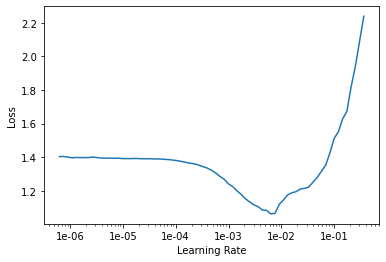

In [10]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,healthy-AUC,multiple_diseases-AUC,rust-AUC,scab-AUC,macro-AUC,time
0,0.807348,0.738432,0.813187,0.946507,0.544953,0.921282,0.984056,0.854987,03:20
1,0.457227,1.111058,0.776557,0.955000,0.577496,0.864043,0.925349,0.835537,03:19
2,0.327620,0.665469,0.904762,0.952842,0.885273,0.941716,0.938759,0.934274,03:19
3,0.235617,0.420331,0.908425,0.987055,0.886928,0.987693,0.994129,0.969172,03:18
4,0.176991,0.225230,0.952381,0.996575,0.935742,0.997562,0.996230,0.984067,03:18
5,0.127076,0.181649,0.952381,0.997877,0.954220,0.997794,0.997157,0.988917,03:18


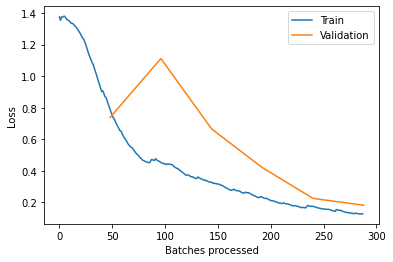

In [11]:
learn.fit_one_cycle(6, max_lr=1e-3)
learn.recorder.plot_losses()
learn.save('draft-efficientnet-B3')

epoch,train_loss,valid_loss,accuracy,healthy-AUC,multiple_diseases-AUC,rust-AUC,scab-AUC,macro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


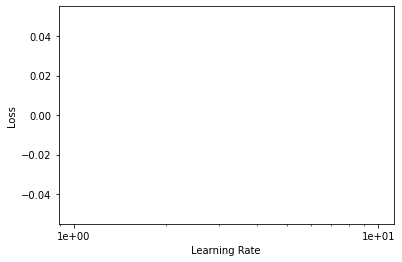

In [12]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,healthy-AUC,multiple_diseases-AUC,rust-AUC,scab-AUC,macro-AUC,time
0,0.096518,0.155159,0.952381,0.998288,0.961114,0.998665,0.997405,0.990777,03:17
1,0.080808,0.119824,0.956044,0.998836,0.982074,0.999478,0.998640,0.995514,03:15
2,0.070182,0.133654,0.956044,0.998836,0.973800,0.999361,0.998949,0.993544,03:16
3,0.060576,0.128986,0.956044,0.998425,0.978764,0.999419,0.998579,0.994486,03:15
4,0.063401,0.118929,0.959707,0.998630,0.979868,0.999652,0.998393,0.994893,03:16


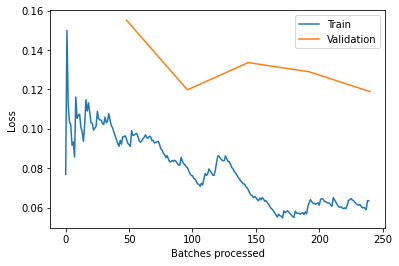

In [13]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=1e-4)
learn.recorder.plot_losses()
learn.save('tuned-efficientnet-B3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


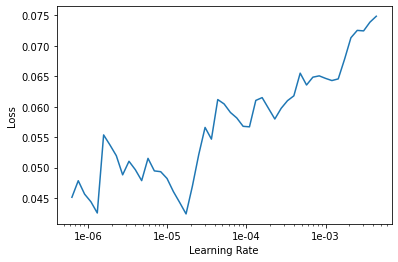

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=1e-6)
learn.save('final-efficientnet-B3')

epoch,train_loss,valid_loss,accuracy,healthy-AUC,multiple_diseases-AUC,rust-AUC,scab-AUC,macro-AUC,time
0,0.050270,0.120377,0.956044,0.998562,0.979316,0.999652,0.998393,0.994807,03:17
1,0.061061,0.120886,0.956044,0.998562,0.978213,0.999652,0.998331,0.994550,03:18
2,0.056579,0.121074,0.956044,0.998699,0.978489,0.999652,0.998331,0.994664,03:18
3,0.051963,0.120982,0.956044,0.998630,0.978489,0.999652,0.998331,0.994646,03:19
4,0.050796,0.121184,0.956044,0.998630,0.978489,0.999652,0.998331,0.994646,03:25


In [16]:
test_df = pd.read_csv('../input/plant-pathology-2020-fgvc7/test.csv')

In [17]:
test = ImageList.from_df(test_df, '../input/plant-pathology-2020-fgvc7/images/', suffix='.jpg')
data.add_test(test)
print(data)

ImageDataBunch;

Train: LabelList (1548 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
3,1,0,2,0
Path: ../input/plant-pathology-2020-fgvc7;

Valid: LabelList (273 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
3,3,2,2,2
Path: ../input/plant-pathology-2020-fgvc7;

Test: LabelList (1821 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: EmptyLabelList
,,,,
Path: ../input/plant-pathology-2020-fgvc7


In [18]:
preds, *_ = learn.get_preds(ds_type=DatasetType.Test)

In [19]:
sub = pd.read_csv('../input/plant-pathology-2020-fgvc7/sample_submission.csv')
for lbl in range(4): 
    sub[[label_dict[lbl]]] = preds.detach().numpy()[:, lbl]
sub.head

<bound method NDFrame.head of        image_id       healthy  multiple_diseases          rust          scab
0        Test_0  9.600871e-05       5.116059e-03  9.947100e-01  7.790705e-05
1        Test_1  4.446622e-05       1.859894e-03  9.980428e-01  5.278958e-05
2        Test_2  2.693367e-09       2.755862e-07  3.856141e-10  9.999998e-01
3        Test_3  9.953198e-01       1.349208e-03  1.721585e-03  1.609379e-03
4        Test_4  1.729724e-06       1.833805e-04  9.998122e-01  2.709254e-06
...         ...           ...                ...           ...           ...
1816  Test_1816  6.549956e-08       1.240310e-04  9.998752e-01  7.527325e-07
1817  Test_1817  2.048802e-04       8.666389e-02  1.066211e-03  9.120650e-01
1818  Test_1818  1.787848e-04       4.128606e-03  9.956248e-01  6.773338e-05
1819  Test_1819  9.992061e-01       2.086031e-04  3.927185e-04  1.925513e-04
1820  Test_1820  2.988821e-07       8.161727e-05  4.029546e-07  9.999176e-01

[1821 rows x 5 columns]>

In [20]:
sub.to_csv('submission.csv', index=False)